In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
valid_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [42]:
print train_targets.shape

(6680, 133)


In [43]:
all_targets = np.vstack([train_targets, valid_targets, test_targets])


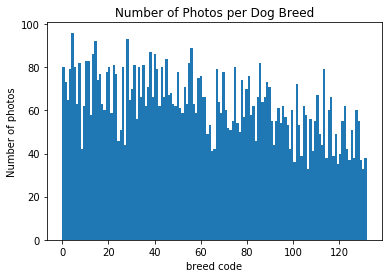

In [100]:
x =  np.argmax(all_targets,axis=1)
plt.title("Number of Photos per Dog Breed")
plt.xlabel("breed code")
plt.ylabel("Number of photos")
plt.hist(x, bins=133);
plt.savefig('plots/histogram.png')

In [102]:
%matplotlib inline
num_per_class = []
total = 0
for i in range(133):
    per_class_i = len(np.where(np.argmax(all_targets, axis = 1) == i)[0])
    num_per_class.append(per_class_i)
    total+=per_class_i
    
num_per_class_array = np.array(num_per_class)

# print num_per_class_array

hist, bin_edges=np.histogram(num_per_class_array, bins='auto')
# print hist

min_i = np.argmin(num_per_class)
max_i = np.argmax(num_per_class)
print dog_names[min_i],num_per_class[min_i]
print dog_names[max_i],num_per_class[max_i]

Norwegian_buhund 33
Alaskan_malamute 96


In [2]:
print(dog_names)

['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Collie',

In [3]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

100%|██████████| 10/10 [00:00<00:00, 268.75it/s]

(224, 224, 3)


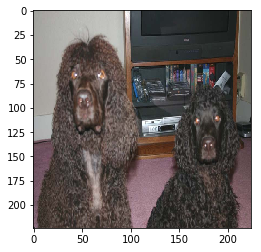

In [5]:
import PIL
from matplotlib import pyplot as plt
plt.ion()

a = paths_to_tensor(train_files[0:10])
print a[2].shape
im_example = PIL.Image.fromarray(np.uint8(a[2]))
plt.imshow(im_example)

In [ ]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

img = preprocess_input(a)
decode_predictions(ResNet50_model.predict(img), top=1)


In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [ ]:
np.save(open('train_tensors.npy', 'w'), train_tensors)
np.save(open('valid_tensors.npy', 'w'), valid_tensors)
np.save(open('test_tensors.npy', 'w'), test_tensors)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    shear_range = 0.2, # rnadomly applying shear transformation
    zoom_range = 0.2, # randomly zooming inside pictures
    fill_mode = 'nearest')
# fit augmented image generator on data
datagen.fit(train_tensors)

In [ ]:
print(train_tensors.shape)

In [286]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# Use with data augmentation example
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(266, activation='relu'))
model.add(Dropout(0.5))
# END: Use with data augmentation example


model.add(Dense(133, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_31 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 54, 54, 32)        128       
__________

In [ ]:
# NO DATA AUGMENTATION

from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping

epochs = 200
batch_size = 16

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_not_augmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
model.fit(train_tensors, train_targets, batch_size=batch_size,
                    validation_data=(valid_tensors, valid_targets), 
                    epochs=epochs, callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)], verbose=1)

In [287]:
model.load_weights('saved_models/weights.best_not_augmented.from_scratch.hdf5')

ValueError: You are trying to load a weight file containing 12 layers into a model with 13 layers.

In [ ]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
pic_i = 16
print(np.argmax(model.predict(test_tensors[pic_i:pic_i+1])))
print(model.predict(test_tensors[pic_i:pic_i+1]).argsort())
print(np.argmax(test_targets[pic_i]))

In [ ]:
# WITH DATA AUGMENTATION (need to recompile the model before running)

from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping

epochs = 10
batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)], verbose=1)

In [290]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

In [291]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 57.0000%


In [ ]:
print(np.argmax(model.predict(test_tensors[4:5])))
print(model.predict(test_tensors[4:5]).argsort())
print(np.argmax(test_targets[4]))

In [6]:
import numpy as np
train_tensors_original = np.load(open('train_tensors_original.npy'))
test_tensors_original = np.load(open('test_tensors_original.npy'))
valid_tensors_original = np.load(open('valid_tensors_original.npy'))


In [7]:
# Transfer Learning. RESNET50
from keras.applications.resnet50 import ResNet50
resnet = ResNet50(include_top=False, weights='imagenet')
print "Done extracting features"

Done extracting features


In [ ]:
train_tensors_original = train_tensors * 255
valid_tensors_original = valid_tensors * 255
test_tensors_original = test_tensors * 255


[[[  65.   80.   77.]
  [  66.   81.   78.]
  [  68.   83.   80.]
  ..., 
  [ 219.  246.  255.]
  [ 219.  246.  255.]
  [ 219.  246.  255.]]

 [[  64.   79.   76.]
  [  65.   80.   77.]
  [  68.   83.   80.]
  ..., 
  [ 219.  246.  255.]
  [ 219.  246.  255.]
  [ 219.  246.  255.]]

 [[  61.   76.   73.]
  [  63.   78.   75.]
  [  68.   83.   80.]
  ..., 
  [ 219.  246.  255.]
  [ 219.  246.  255.]
  [ 219.  246.  255.]]

 ..., 
 [[  91.  115.  151.]
  [  79.  102.  136.]
  [  16.   34.   58.]
  ..., 
  [  10.   34.   60.]
  [  54.   72.   96.]
  [  64.   82.  106.]]

 [[  91.  115.  151.]
  [  70.   93.  127.]
  [   9.   27.   51.]
  ..., 
  [  15.   39.   67.]
  [  44.   61.   87.]
  [  50.   67.   93.]]

 [[  99.  123.  159.]
  [  83.  106.  140.]
  [  24.   42.   66.]
  ..., 
  [  17.   40.   71.]
  [  37.   54.   82.]
  [  39.   56.   84.]]]


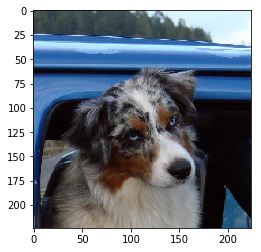

In [8]:
print(train_tensors_original[10])
im_example = PIL.Image.fromarray(np.uint8(train_tensors_original[10]))
plt.imshow(im_example)

In [9]:
from keras.applications.resnet50 import preprocess_input
train_tensors1 = preprocess_input(train_tensors_original)
valid_tensors1 = preprocess_input(valid_tensors_original)
test_tensors1 = preprocess_input(test_tensors_original)

In [10]:
train_resnet_features = resnet.predict(train_tensors1)
print(train_resnet_features.shape)

(6680, 1, 1, 2048)


In [11]:
valid_resnet_features = resnet.predict(valid_tensors1)
print(valid_resnet_features.shape)

(835, 1, 1, 2048)


In [12]:
test_resnet_features = resnet.predict(test_tensors1)
print(test_resnet_features.shape)

(836, 1, 1, 2048)


In [13]:
np.save(open('bottleneck_features//train_resnet_features.npy', 'w'), train_resnet_features)
np.save(open('bottleneck_features//valid_resnet_features.npy', 'w'), valid_resnet_features)
np.save(open('bottleneck_features//test_resnet_features.npy', 'w'), test_resnet_features)

In [21]:
import numpy as np
train_resnet_features = np.load(open('bottleneck_features//train_resnet_features.npy'))
valid_resnet_features = np.load(open('bottleneck_features//valid_resnet_features.npy'))
test_resnet_features = np.load(open('bottleneck_features//test_resnet_features.npy'))


In [4]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet_features = bottleneck_features['train']
valid_resnet_features = bottleneck_features['valid']
test_resnet_features = bottleneck_features['test']

In [14]:
print(train_resnet_features.shape)

(6680, 1, 1, 2048)


In [15]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D


ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_resnet_features.shape[1:]))
ResNet_model.add(Dropout(0.5))

ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=1, save_best_only=True)


ResNet_model.fit(train_resnet_features, train_targets, 
          batch_size = 128,
          epochs=30,
          verbose=1,
          validation_data=(valid_resnet_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 1s 192us/step - loss: 3.4997 - acc: 0.2386 - val_loss: 1.4721 - val_acc: 0.6539
Epoch 2/30
6680/6680 [==============================] - 0s 40us/step - loss: 1.2474 - acc: 0.6621 - val_loss: 0.9131 - val_acc: 0.7497
Epoch 3/30
6680/6680 [==============================] - 0s 39us/step - loss: 0.7954 - acc: 0.7795 - val_loss: 0.7860 - val_acc: 0.7749
Epoch 4/30
6680/6680 [==============================] - 0s 40us/step - loss: 0.6027 - acc: 0.8329 - val_loss: 0.6953 - val_acc: 0.7868
Epoch 5/30
6680/6680 [==============================] - 0s 39us/step - loss: 0.4772 - acc: 0.8639 - val_loss: 0.6442 - val_acc: 0.8084
Epoch 6/30
6680/6680 [==============================] - 0s 40us/step - loss: 0.3862 - acc: 0.8958 - val_loss: 0.6133 - val_acc: 0.8132
Epoch 7/30
6680/6680 [==============================] - 0s 39us/step - loss: 0.3254 - acc: 0.9145 - val_loss: 0.6092 - val_acc: 0.8084
Epoch 8

6680/6680 [==============================] - 0s 39us/step - loss: 0.0539 - acc: 0.9913 - val_loss: 0.5587 - val_acc: 0.8299
Epoch 30/30
6680/6680 [==============================] - 0s 36us/step - loss: 0.0542 - acc: 0.9909 - val_loss: 0.5646 - val_acc: 0.8168


In [17]:
### Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/weights.best.resnet.hdf5')

In [18]:
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0000%


In [ ]:
# INCEPTION

In [ ]:
from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(include_top=False, weights='imagenet')
print "Done extracting features"

In [ ]:
from keras.applications.inception_v3 import preprocess_input
train_tensors2 = preprocess_input(train_tensors_original)
valid_tensors2 = preprocess_input(valid_tensors_original)
test_tensors2 = preprocess_input(test_tensors_original)

In [ ]:
train_inception_features = inception.predict(train_tensors2)
print(train_inception_features.shape)

In [ ]:
valid_inception_features = inception.predict(valid_tensors2)
print(valid_inception_features.shape)

In [ ]:
test_inception_features = inception.predict(test_tensors2)
print(test_inception_features.shape)

In [ ]:
np.save(open('bottleneck_features//train_inception_features.npy', 'w'), train_inception_features)
np.save(open('bottleneck_features//valid_inception_features.npy', 'w'), valid_inception_features)
np.save(open('bottleneck_features//test_inception_features.npy', 'w'), test_inception_features)

In [ ]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception_features = bottleneck_features['train']
valid_inception_features = bottleneck_features['valid']
test_inception_features = bottleneck_features['test']

In [ ]:
print(train_inception_features.shape)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers

Inception_model = Sequential()

Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_inception_features.shape[1:]))
Inception_model.add(Dropout(0.5))
Inception_model.add(Dense(133, activation='softmax'))
Inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Inception_model.summary()

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=1, save_best_only=True)


score = Inception_model.fit(train_inception_features, train_targets, 
          batch_size = 8,
          epochs=30,
          verbose=1,
          validation_data=(valid_inception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

In [334]:
### Load the model weights with the best validation loss.
Inception_model.load_weights('saved_models/weights.best.inception.hdf5')

In [335]:
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.0000%


In [ ]:
#XCEPTION

In [ ]:
from keras.applications.xception import Xception
xception = Xception(include_top=False, weights='imagenet')
print "Done extracting features"

In [ ]:
from keras.applications.xception import preprocess_input
train_tensors3 = preprocess_input(train_tensors_original)
valid_tensors3 = preprocess_input(valid_tensors_original)
test_tensors3 = preprocess_input(test_tensors_original)

In [ ]:
train_xception_features = xception.predict(train_tensors3)
print(train_xception_features.shape)

In [ ]:
valid_xception_features = xception.predict(valid_tensors3)
print(valid_xception_features.shape)

In [ ]:
test_xception_features = xception.predict(test_tensors3)
print(test_xception_features.shape)

In [ ]:
np.save(open('bottleneck_features//train_xception_features.npy', 'w'), train_xception_features)
np.save(open('bottleneck_features//valid_xception_features.npy', 'w'), valid_xception_features)
np.save(open('bottleneck_features//test_xception_features.npy', 'w'), test_xception_features)

In [ ]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_xception_features = bottleneck_features['train']
valid_xception_features = bottleneck_features['valid']
test_xception_features = bottleneck_features['test']

In [ ]:
print(train_xception_features.shape)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers

Xception_model = Sequential()

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_xception_features.shape[1:]))
Xception_model.add(Dropout(0.5))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Xception_model.summary()

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)


score = Xception_model.fit(train_xception_features, train_targets, 
          batch_size = 16,
          epochs=30,
          verbose=1,
          validation_data=(valid_xception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

In [336]:
### Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.xception.hdf5')

In [337]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.0000%


In [ ]:
from keras.applications.vgg19 import VGG19
vgg19 = VGG19(include_top=False, weights='imagenet')
print "Done extracting features"

In [ ]:
from keras.applications.vgg19 import preprocess_input
train_tensors4 = preprocess_input(train_tensors_original)
valid_tensors4 = preprocess_input(valid_tensors_original)
test_tensors4 = preprocess_input(test_tensors_original)

In [ ]:
train_vgg19_features = vgg19.predict(train_tensors4)
print(train_vgg19_features.shape)

In [ ]:
valid_vgg19_features = vgg19.predict(valid_tensors4)
print(valid_vgg19_features.shape)

In [ ]:
test_vgg19_features = vgg19.predict(test_tensors4)
print(test_vgg19_features.shape)

In [ ]:
np.save(open('bottleneck_features//train_vgg19_features.npy', 'w'), train_vgg19_features)
np.save(open('bottleneck_features//valid_vgg19_features.npy', 'w'), valid_vgg19_features)
np.save(open('bottleneck_features//test_vgg19_features.npy', 'w'), test_vgg19_features)

In [ ]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_vgg19_features = bottleneck_features['train']
valid_vgg19_features = bottleneck_features['valid']
test_vgg19_features = bottleneck_features['test']

In [ ]:
print(train_vgg19_features.shape)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers

vgg19_model = Sequential()


vgg19_model = Sequential()
# vgg19_model.add(Flatten(input_shape=train_vgg19_features[0].shape))
vgg19_model.add(GlobalAveragePooling2D(input_shape=train_vgg19_features.shape[1:]))

# model.add(Dense(10 * len(breed_codes),activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(6 * len(breed_codes),activation='relu'))
# model.add(Dropout(0.5))

vgg19_model.add(Dense(2 * 133,activation='relu'))
vgg19_model.add(Dropout(0.5))

vgg19_model.add(Dense(2 * 133,activation='relu'))
vgg19_model.add(Dropout(0.5))

vgg19_model.add(Dense(133, activation='softmax'))

vgg19_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg19_model.summary()

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg19.hdf5', 
                               verbose=1, save_best_only=True)


score = vgg19_model.fit(train_vgg19_features, train_targets, 
          batch_size = 64,
          epochs=30,
          verbose=1,
          validation_data=(valid_vgg19_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

In [338]:
### Load the model weights with the best validation loss.
vgg19_model.load_weights('saved_models/weights.best.vgg19.hdf5')

In [339]:
vgg19_predictions = [np.argmax(vgg19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg19_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(vgg19_predictions)==np.argmax(test_targets, axis=1))/len(vgg19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.0000%


In [ ]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, weights='imagenet')
print "Done extracting features"

In [ ]:
from keras.applications.vgg16 import preprocess_input
train_tensors4 = preprocess_input(train_tensors_original)
valid_tensors4 = preprocess_input(valid_tensors_original)
test_tensors4 = preprocess_input(test_tensors_original)

In [ ]:
train_vgg16_features = vgg16.predict(train_tensors4)
print(train_vgg16_features.shape)

In [ ]:
valid_vgg16_features = vgg16.predict(valid_tensors4)
print(valid_vgg16_features.shape)

In [ ]:
test_vgg16_features = vgg16.predict(test_tensors4)
print(test_vgg16_features.shape)

In [ ]:
np.save(open('bottleneck_features//train_vgg16_features.npy', 'w'), train_vgg16_features)
np.save(open('bottleneck_features//valid_vgg16_features.npy', 'w'), valid_vgg16_features)
np.save(open('bottleneck_features//test_vgg16_features.npy', 'w'), test_vgg16_features)

In [ ]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_vgg16_features = bottleneck_features['train']
valid_vgg16_features = bottleneck_features['valid']
test_vgg16_features = bottleneck_features['test']

In [ ]:
print(train_vgg16_features.shape)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers

vgg16_model = Sequential()

vgg16_model = Sequential()
vgg16_model.add(GlobalAveragePooling2D(input_shape=train_vgg16_features.shape[1:]))

vgg16_model.add(Dense(2 * 133,activation='relu'))
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Dense(2 * 133,activation='relu'))
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Dense(133, activation='softmax'))


vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg16_model.summary()

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg16.hdf5', 
                               verbose=1, save_best_only=True)


score = vgg16_model.fit(train_vgg16_features, train_targets, 
          batch_size = 64,
          epochs=30,
          verbose=1,
          validation_data=(valid_vgg16_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

In [ ]:
### Load the model weights with the best validation loss.
vgg16_model.load_weights('saved_models/weights.best.vgg16.hdf5')

In [ ]:
vgg16_predictions = [np.argmax(vgg16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg16_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(vgg16_predictions)==np.argmax(test_targets, axis=1))/len(vgg16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
# ENSEMBLE

In [ ]:
print np.where(np.array(Xception_predictions)!=np.argmax(test_targets, axis=1))

In [ ]:
print np.where(np.array(Inception_predictions)!=np.argmax(test_targets, axis=1))

In [ ]:
print np.where(np.array(ResNet50_predictions)!=np.argmax(test_targets, axis=1))

In [ ]:
print np.where(np.array(vgg19_predictions)!=np.argmax(test_targets, axis=1))

In [ ]:
print np.where(np.array(vgg16_predictions)!=np.argmax(test_targets, axis=1))

In [275]:
vgg16_predict_weights = vgg16_model.predict(valid_vgg16_features)
vgg19_predict_weights = vgg19_model.predict(valid_vgg19_features)
resnet_predict_weights = ResNet_model.predict(valid_resnet_features)
inception_predict_weights = Inception_model.predict(valid_inception_features)
xception_predict_weights = Xception_model.predict(valid_xception_features)

In [295]:
vgg16_valid_accuracy = 1.0*np.sum(np.argmax(vgg16_predict_weights, axis = 1)==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
vgg19_valid_accuracy = 1.0*np.sum(np.argmax(vgg19_predict_weights, axis = 1)==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
resnet_valid_accuracy = 1.0*np.sum(np.argmax(resnet_predict_weights, axis = 1)==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
inception_valid_accuracy = 1.0*np.sum(np.argmax(inception_predict_weights, axis = 1)==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
xception_valid_accuracy = 1.0*np.sum(np.argmax(xception_predict_weights, axis = 1)==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)

In [300]:
print vgg19_valid_accuracy

0.779640718563


In [313]:
ensemble_weights =  np.add(vgg16_valid_accuracy*vgg16_predict_weights, vgg19_valid_accuracy*vgg19_predict_weights)
ensemble_weights = np.add(ensemble_weights, resnet_valid_accuracy*resnet_predict_weights)
ensemble_weights = np.add(ensemble_weights, inception_valid_accuracy*inception_predict_weights)
ensemble_weights = np.add(ensemble_weights, xception_valid_accuracy*xception_predict_weights)
print ensemble_weights.shape

(835, 133)


In [314]:
ensemble_predictions = np.argmax(ensemble_weights, axis = 1)

In [315]:
print np.where(ensemble_predictions!=np.argmax(valid_targets, axis=1))

(array([  1,   5,  11,  24,  26,  67,  69,  72,  94, 100, 120, 134, 152,
       160, 166, 168, 178, 179, 191, 197, 198, 214, 222, 235, 259, 261,
       276, 283, 293, 295, 296, 307, 322, 324, 326, 333, 353, 374, 381,
       411, 415, 416, 418, 442, 461, 470, 472, 480, 484, 487, 490, 498,
       526, 533, 535, 557, 559, 560, 573, 580, 592, 598, 611, 628, 637,
       639, 643, 661, 686, 712, 724, 728, 733, 734, 738, 746, 752, 753,
       757, 760, 777, 780, 817]),)


In [333]:
valid_accuracy = 100*np.sum(ensemble_predictions==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
print('Test accuracy: %.4f%%' % valid_accuracy)

Test accuracy: 90.0000%


In [325]:
vgg16_pr = np_utils.to_categorical( np.argmax(vgg16_predict_weights, axis = 1), 133)
vgg19_pr = np_utils.to_categorical( np.argmax(vgg19_predict_weights, axis = 1), 133)
resnet_pr = np_utils.to_categorical( np.argmax(resnet_predict_weights, axis = 1), 133)
inception_pr = np_utils.to_categorical( np.argmax(inception_predict_weights, axis = 1), 133)
xception_pr = np_utils.to_categorical( np.argmax(xception_predict_weights, axis = 1), 133)


In [326]:
ensemble_pr =  np.add(vgg16_valid_accuracy*vgg16_pr, vgg19_valid_accuracy*vgg19_pr)
ensemble_pr = np.add(ensemble_pr, resnet_valid_accuracy*resnet_pr)
ensemble_pr = np.add(ensemble_pr, inception_valid_accuracy*inception_pr)
ensemble_pr = np.add(ensemble_pr, xception_valid_accuracy*xception_pr)
print ensemble_pr.shape

(835, 133)


In [341]:
valid_accuracy = 100*np.sum(ensemble_majority==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
print('Test accuracy: %.4f%%' % valid_accuracy)

Test accuracy: 88.0000%
